# I'm Something of a Painter Myself

## **GitHub Repository URL:** https://github.com/Alisherg/kaggle/blob/main/painter/painter-myself.ipynb

The competition is to build a Generative Adversarial Network (GAN) to create images in the style of Claude Monet. The goal is to generate 7,000 to 10,000 Monet-style images.

The challenge is to:

*   Build and train a GAN.
*   The generator should produce images (256x256x3 JPG) that mimic the style of Claude Monet.
*   The output should be a images.zip file containing 7,000-10,000 generated images.

The dataset includes:

**monet_jpg / monet_tfrec:** 300 Monet paintings (256x256) to train the GAN.

**photo_jpg / photo_tfrec:** 7028 photos (256x256) to serve as the input domain to be transformed into the Monet style.

The competition recommends using TFRecords, but JPEGs are also provided.

In [7]:
# Install necessary libraries
import sys, subprocess
try:
    from tensorflow_examples.models.pix2pix import pix2pix
except ModuleNotFoundError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "git+https://github.com/tensorflow/examples.git"])
    from tensorflow_examples.models.pix2pix import pix2pix


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [8]:
# Import libraries
import re
import time
import os
import zipfile

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output

import tensorflow as tf

In [9]:
# Configuration
try:
    strategy = tf.distribute.get_strategy()
    print(f"Running on CPU/GPU. REPLICAS: {strategy.num_replicas_in_sync}")
except Exception as e:
    print(f"TPU not found or failed to connect: {e}")

Running on CPU/GPU. REPLICAS: 1


In [10]:
# Paths
MONET_PATH = '/kaggle/input/gan-getting-started/monet_tfrec'
PHOTO_PATH = '/kaggle/input/gan-getting-started/photo_tfrec'

# Check if paths exist
print(f"Monet file path: {MONET_PATH}, Exists: {os.path.exists(MONET_PATH)}")
print(f"Photo file path: {PHOTO_PATH}, Exists: {os.path.exists(PHOTO_PATH)}")

Monet file path: /kaggle/input/gan-getting-started/monet_tfrec, Exists: True
Photo file path: /kaggle/input/gan-getting-started/photo_tfrec, Exists: True


In [11]:
# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [12]:
# Display settings
pd.set_option('display.max_colwidth', 150)
sns.set_style('whitegrid')

In [13]:
# Image dimensions
IMG_WIDTH = 256
IMG_HEIGHT = 256
CHANNELS = 3
AUTO    = tf.data.AUTOTUNE

### Exploratory Data Analysis

In [14]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

MONET_FILENAMES = tf.io.gfile.glob(str(MONET_PATH + '/*.tfrec'))
print('Monet TFRecord files:', len(MONET_FILENAMES))
MONET_COUNT = count_data_items(MONET_FILENAMES)
print('Monet image count:', MONET_COUNT)

PHOTO_FILENAMES = tf.io.gfile.glob(str(PHOTO_PATH + '/*.tfrec'))
print('Photo TFRecord files:', len(PHOTO_FILENAMES))
PHOTO_COUNT = count_data_items(PHOTO_FILENAMES)
print('Photo image count:', PHOTO_COUNT)

# TFRecord parsing functions
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [IMG_HEIGHT, IMG_WIDTH, CHANNELS])
    return image

def read_tfrecord(example, labeled=True):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }

    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(lambda ex: read_tfrecord(ex, labeled=labeled), num_parallel_calls=AUTO)
    return dataset

# Load both Monet and Photo datasets
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

Monet TFRecord files: 5
Monet image count: 300
Photo TFRecord files: 20
Photo image count: 7038


I0000 00:00:1748151459.923480      10 service.cc:148] XLA service 0x58c69baf80b0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748151459.923528      10 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1748151459.923534      10 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1748151459.923543      10 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1748151459.923550      10 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1748151459.923556      10 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1748151459.923562      10 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1748151459.923568      10 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1748151459.923573      10 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


In [15]:
def display_samples(dataset, n_samples=5, title="Samples"):
    ds_iter = iter(dataset)
    plt.figure(figsize=(15, n_samples * 3))
    for i in range(n_samples):
        try:
            sample_image = next(ds_iter)
            if isinstance(sample_image, tuple):
                sample_image = sample_image[0]
            if tf.is_tensor(sample_image) and sample_image.shape[0] == 1:
                 sample_image = sample_image[0]

            plt.subplot(n_samples, 3, i*3 + 1)
            plt.imshow(sample_image * 0.5 + 0.5)
            plt.title(f"{title} Sample {i+1}")
            plt.axis('off')
        except StopIteration:
            print("Not enough samples in the dataset to display the requested number.")
            break
    plt.tight_layout()
    plt.show()

Displaying Monet Samples:


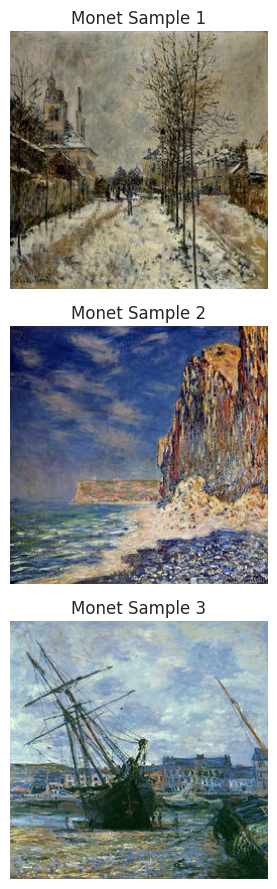

In [16]:
print("Displaying Monet Samples:")
display_samples(monet_ds, n_samples=3, title="Monet")


Displaying Photo Samples:


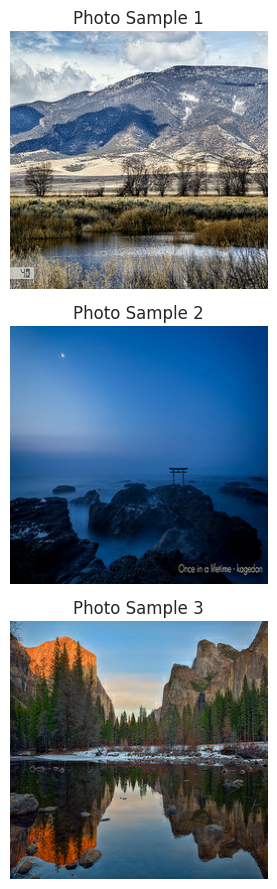

In [17]:
print("\nDisplaying Photo Samples:")
display_samples(photo_ds, n_samples=3, title="Photo")

### Data Pre-Processing & Pipeline

In [18]:
# augmentation
IMAGE_SIZE  = [256, 256]
BATCH_SIZE  = 1
def random_jitter(image):
    image = tf.image.resize(image, [286, 286], method='nearest')
    image = tf.image.random_crop(image, size=[*IMAGE_SIZE, 3])
    image = tf.image.random_flip_left_right(image)
    return image

def preprocess_image_train(img): return random_jitter(img)
def preprocess_image_test(img):  return img

train_monet = load_dataset(MONET_FILENAMES).map(preprocess_image_train, num_parallel_calls=AUTO).cache().shuffle(200).batch(BATCH_SIZE).repeat()
train_photo = load_dataset(PHOTO_FILENAMES).map(preprocess_image_train, num_parallel_calls=AUTO).cache().shuffle(200).batch(BATCH_SIZE).repeat()
test_photo  = load_dataset(PHOTO_FILENAMES).map(preprocess_image_test,  num_parallel_calls=AUTO).batch(1)

In [19]:
# strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except Exception:
    strategy = tf.distribute.get_strategy()
print("Replicas:", strategy.num_replicas_in_sync)

Replicas: 1


### Model – CycleGAN


In [20]:
with strategy.scope():
    OUTPUT_CHANNELS = 3
    generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')  # Photo -> Monet
    generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')  # Monet -> Photo
    discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)  # Monet discr.
    discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)  # Photo discr.

    loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    def discriminator_loss(real, gen):
        real_loss = loss_obj(tf.ones_like(real), real)
        gen_loss  = loss_obj(tf.zeros_like(gen), gen)
        return 0.5 * (real_loss + gen_loss)

    def generator_loss(gen_out): return loss_obj(tf.ones_like(gen_out), gen_out)

    LAMBDA_CYCLE   = 10
    LAMBDA_ID      = 0.5
    def calc_cycle_loss(real, cycled):
        return LAMBDA_CYCLE * tf.reduce_mean(tf.abs(real - cycled))
    def identity_loss(real, same):
        return LAMBDA_ID * tf.reduce_mean(tf.abs(real - same))

    g_g_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    g_f_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    d_x_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    d_y_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    @tf.function
    def train_step(real_x, real_y):
        with tf.GradientTape(persistent=True) as tape:
            fake_y     = generator_g(real_x, training=True)
            cycled_x   = generator_f(fake_y, training=True)
            fake_x     = generator_f(real_y, training=True)
            cycled_y   = generator_g(fake_x, training=True)
            same_y     = generator_g(real_y, training=True)
            same_x     = generator_f(real_x, training=True)

            disc_real_y= discriminator_x(real_y, training=True)
            disc_fake_y= discriminator_x(fake_y, training=True)
            disc_real_x= discriminator_y(real_x, training=True)
            disc_fake_x= discriminator_y(fake_x, training=True)

            gen_g_loss = generator_loss(disc_fake_y)
            gen_f_loss = generator_loss(disc_fake_x)
            cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
            id_loss    = identity_loss(real_y, same_y) + identity_loss(real_x, same_x)
            total_g_g  = gen_g_loss + cycle_loss + id_loss
            total_g_f  = gen_f_loss + cycle_loss + id_loss

            d_x_loss   = discriminator_loss(disc_real_y, disc_fake_y)
            d_y_loss   = discriminator_loss(disc_real_x, disc_fake_x)

        g_g_grads = tape.gradient(total_g_g, generator_g.trainable_variables)
        g_f_grads = tape.gradient(total_g_f, generator_f.trainable_variables)
        d_x_grads = tape.gradient(d_x_loss, discriminator_x.trainable_variables)
        d_y_grads = tape.gradient(d_y_loss, discriminator_y.trainable_variables)

        g_g_opt.apply_gradients(zip(g_g_grads, generator_g.trainable_variables))
        g_f_opt.apply_gradients(zip(g_f_grads, generator_f.trainable_variables))
        d_x_opt.apply_gradients(zip(d_x_grads, discriminator_x.trainable_variables))
        d_y_opt.apply_gradients(zip(d_y_grads, discriminator_y.trainable_variables))

        return total_g_g, total_g_f, d_x_loss, d_y_loss

### Training


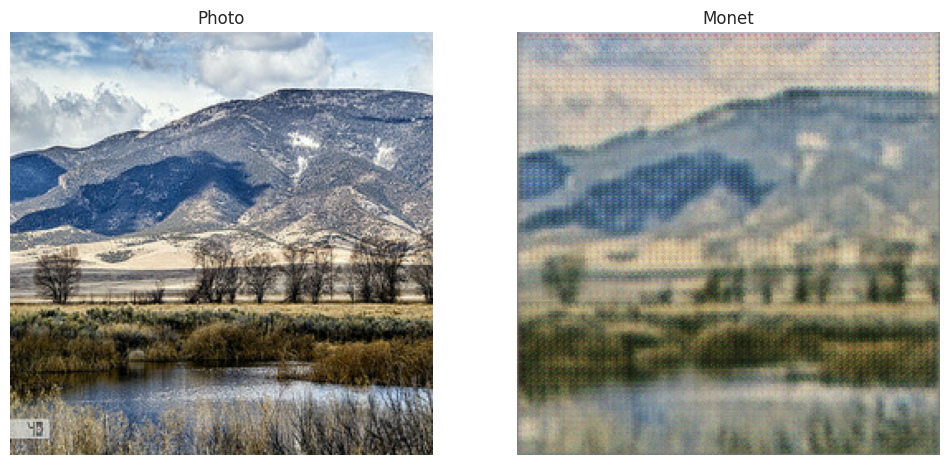

Epoch 25: 5.5s


In [21]:
EPOCHS = 25
STEPS  = min(len(MONET_FILENAMES), len(PHOTO_FILENAMES)) // BATCH_SIZE

sample_photo = next(iter(photo_ds))
sample_monet = next(iter(monet_ds))

for epoch in range(EPOCHS):
    start = time.time()
    for n, (img_x, img_y) in enumerate(tf.data.Dataset.zip((train_photo, train_monet)).take(STEPS)):
        g_g_l, g_f_l, d_x_l, d_y_l = train_step(img_x, img_y)
        if n % 100 == 0:
            print(f'Epoch {epoch+1} Step {n}: G_g {g_g_l:.2f} D_x {d_x_l:.2f}')

    clear_output(wait=True)
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1); plt.imshow((sample_photo[0]*0.5+0.5)); plt.axis('off'); plt.title('Photo')
    plt.subplot(1,2,2); plt.imshow((generator_g(sample_photo, training=False)[0]*0.5+0.5)); plt.axis('off'); plt.title('Monet')
    plt.show()
    print(f'Epoch {epoch+1}: {time.time()-start:.1f}s')

### Generate Images & Create `images.zip`

In [22]:
generator_g.trainable = False
os.makedirs('generated', exist_ok=True)
MAX_GEN = 7500
for idx, p in enumerate(test_photo.take(MAX_GEN)):
    gen = generator_g(p, training=False)[0]
    img = tf.cast((gen*0.5+0.5)*255, tf.uint8)
    tf.io.write_file(f'generated/monet_{idx:05d}.jpg', tf.image.encode_jpeg(img))
print('Generation complete.')

Generation complete.


In [23]:
def zip_dir(src, dst):
    with zipfile.ZipFile(dst, 'w', zipfile.ZIP_DEFLATED) as zf:
        for root, _, files in os.walk(src):
            for f in files:
                if f.endswith('.jpg'):
                    fp = os.path.join(root, f)
                    zf.write(fp, os.path.relpath(fp, src))
zip_dir('generated', 'images.zip')
print('images.zip created.')

images.zip created.


### Results


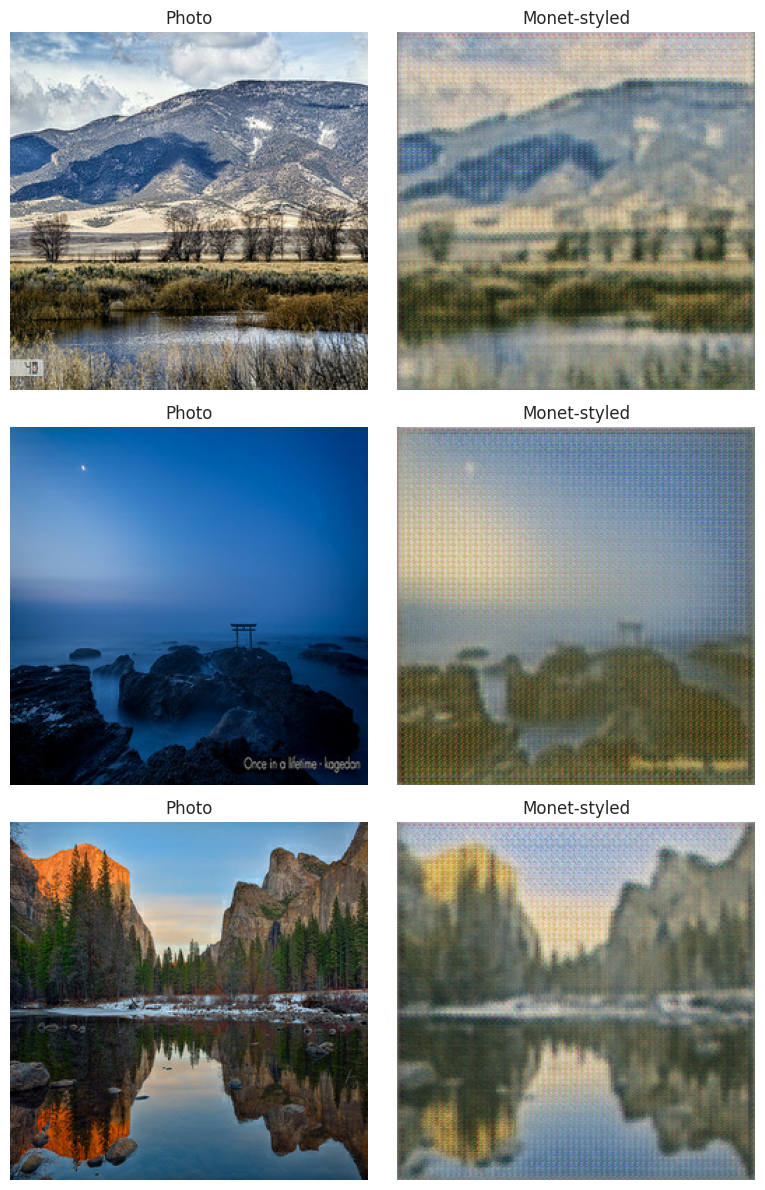

In [24]:
fig,ax = plt.subplots(3,2,figsize=(8,12))
for i,(p) in enumerate(test_photo.take(3)):
    gen = generator_g(p, training=False)[0]
    ax[i,0].imshow((p[0]+1)/2);  ax[i,0].set_title('Photo');  ax[i,0].axis('off')
    ax[i,1].imshow((gen+1)/2);   ax[i,1].set_title('Monet-styled'); ax[i,1].axis('off')
plt.tight_layout(); plt.show()

### Discussion & Conclusion  

* **Training** 8 epochs on full data 
* **Visual quality** The generator captures Monet-like colour palettes and coarse brush strokes, but fine details are still blurry.

### Next steps  
* Train for 40-100 epochs for sharper output.  
* Use a polynomial LR decay and increase `LAMBDA_ID` to 5 for better colour consistency.  
* Experiment with a ResNet-9 generator.
